# Intro

> __NOTE:__ The data that I'm using is scaled TPM data, I may decide to rerun my tests using robust scaled feature counts data

We want to see if there is a correlation between low percent_positive and ihc_score values and being misclassified by the Support Vector Machine and Random Forest algorithms. To start, I will look at how many samples fall in each group within percent_positive and ihc_score.

> It should be noted that some samples may have percent_positive data, and some may have ihc_score data, but there is no guarantee that any given sample will have both or either.

In [1]:
require(readr)
require(dplyr)
require(C50)
require(ggplot2)
require(splitstackshape)

Loading required package: readr
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: C50
Loading required package: ggplot2
Loading required package: splitstackshape


## Load data

First, I will load the dataframe that shows whether SVM and Random Forest were able to accurately predict her2 positivity.
The dataframe looks almost nothing like this, but here is an example:

|Sample        |ERBB2      |... |RF_classified     |SVM_classified   |
| ------------ | --------- | -- | ---------------- | --------------- |
|TCGA...       | 0.3432    |... | Correct          | Misclassified   |

In [2]:
misclassied <- as.data.frame(read_tsv("../data/both_genes_TPM.tsv.gz"))

row.names(misclassied) <- misclassied$Sample

Parsed with column specification:
cols(
  .default = col_double(),
  Sample = col_character(),
  AMY1B = col_integer(),
  AMY1C = col_integer(),
  ANKRD20A1 = col_integer(),
  ANKRD20A2 = col_integer(),
  ANXA8L1 = col_integer(),
  APOC2 = col_integer(),
  APOC4 = col_integer(),
  ARL17B = col_integer(),
  BAGE2 = col_integer(),
  BAGE3 = col_integer(),
  BAGE4 = col_integer(),
  BAGE5 = col_integer(),
  BMS1P1 = col_integer(),
  BMS1P5 = col_integer(),
  BOLA2 = col_integer(),
  BOLA2B = col_integer(),
  BPY2 = col_integer(),
  BPY2B = col_integer(),
  BPY2C = col_integer()
  # ... with 538 more columns
)
See spec(...) for full column specifications.


I will now load the her2 clinical data, which contains her2_percent_positive and ihc_score data

In [3]:
her2.clinical <- as.data.frame(read_tsv("../data/her2_Clinical_Data.tsv"))

her2.clinical$X2 <- NULL
her2.clinical$X3 <- NULL
row.names(her2.clinical) <- her2.clinical$X1
her2.clinical$X1 <- NULL

her2.clinical <- as.data.frame(t(her2.clinical))

Warning message:
“Missing column names filled in: 'X1' [1], 'X2' [2], 'X3' [3]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.


Divide up between her2 positive and her2 negative samples since we are primarily interested in her2 positive samples

In [4]:
positive.percents <- her2.clinical[which(!is.na(her2.clinical$her2_ihc_percent_positive) & 
                                         her2.clinical$her2_ihc_percent_positive != "[Not Available]" & 
                                         her2.clinical$her2_status_by_ihc == "Positive"), 
                                   c('her2_status_by_ihc', 'her2_ihc_percent_positive')]

negative.percents <- her2.clinical[which(!is.na(her2.clinical$her2_ihc_percent_positive) & 
                                         her2.clinical$her2_ihc_percent_positive != "[Not Available]" & 
                                         her2.clinical$her2_status_by_ihc == "Negative"), 
                                   c('her2_status_by_ihc', 'her2_ihc_percent_positive')]

positive.percents$Sample <- row.names(positive.percents)
negative.percents$Sample <- row.names(negative.percents)

In [5]:
positive.scores <- her2.clinical[which(!is.na(her2.clinical$her2_ihc_score) & 
                                       her2.clinical$her2_ihc_score != "[Not Available]" & 
                                       her2.clinical$her2_status_by_ihc == "Positive"), 
                                 c('her2_status_by_ihc', 'her2_ihc_score')]

negative.scores <- her2.clinical[which(!is.na(her2.clinical$her2_ihc_score) & 
                                       her2.clinical$her2_ihc_score != "[Not Available]" & 
                                       her2.clinical$her2_status_by_ihc == "Negative"), 
                                 c('her2_status_by_ihc', 'her2_ihc_score')]

positive.scores$Sample <- rownames(positive.scores)
negative.scores$Sample <- rownames(negative.scores)

# Check spread of percent positive and ihc score data

This will tell us more about the results that we will view later on. First, I want to look at how many samples have either percent positive or ihc score data or both.

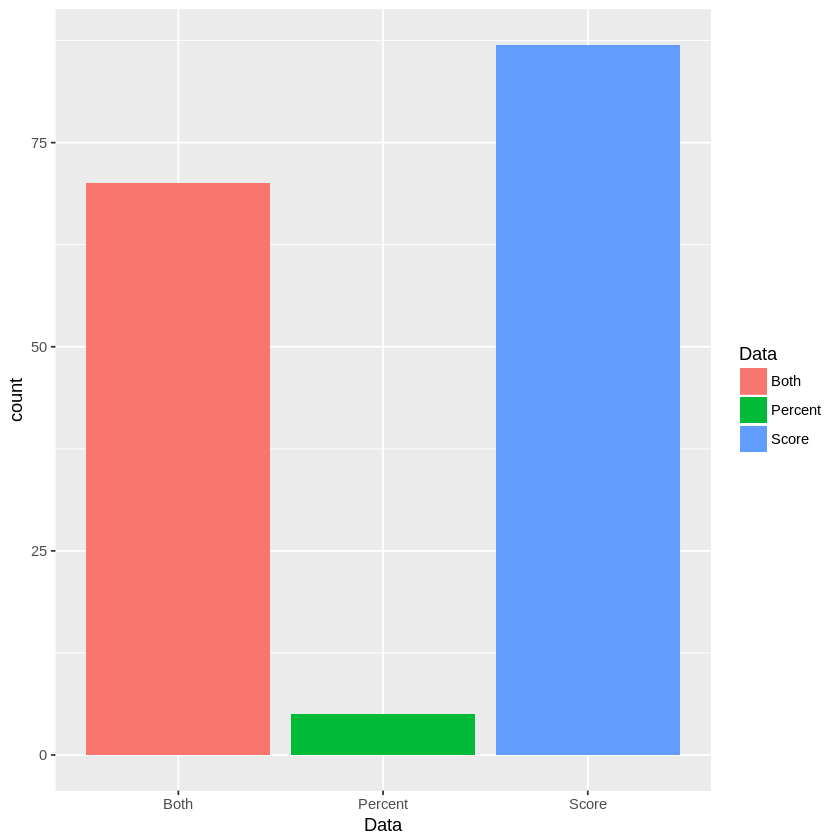

In [6]:
inter.data <- data.frame(Sample = c(positive.percents$Sample, positive.scores$Sample))
inter.data$Data <- ifelse(inter.data$Sample %in% positive.percents$Sample, ifelse(inter.data$Sample %in% positive.scores$Sample, "Both", "Percent"),
                         "Score")

ghist <- ggplot(inter.data, aes(x = Data, fill = Data))

gghist <- ghist + geom_bar()

gghist

Good. It looks like a fair portion has both features, although there is a significant number of samples that only have ihc score data.

Now, let's look at the spread for percent positive.

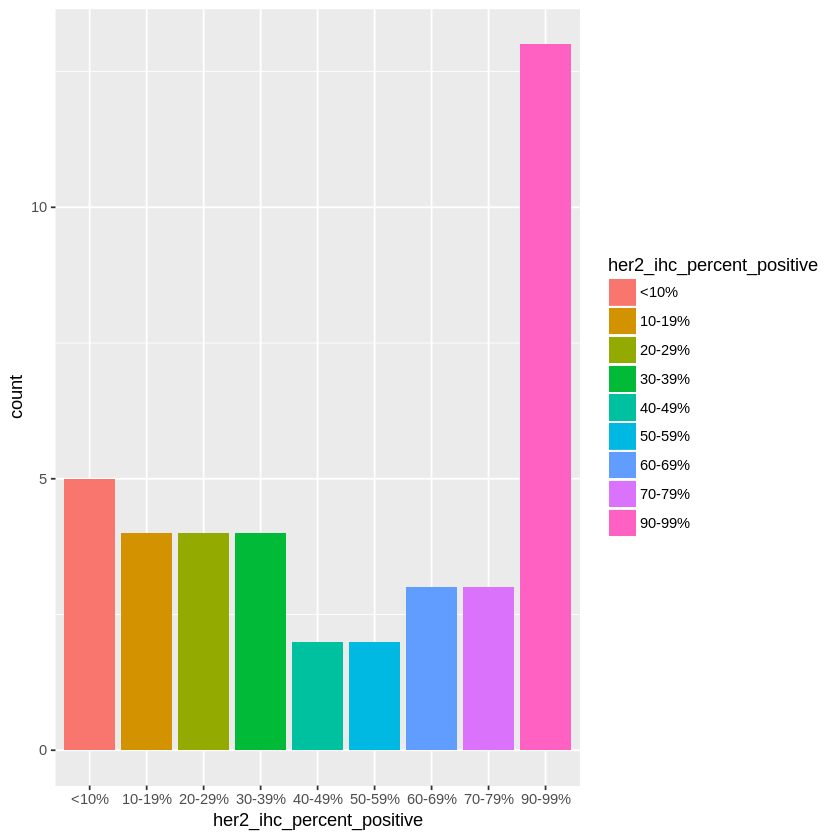

In [7]:
ghist <- ggplot(positive.percents, aes(x = her2_ihc_percent_positive, fill = her2_ihc_percent_positive))

gghist <- ghist + geom_bar()

gghist

It seems that most of the her2 positive samples are found in the 90-99% range, however, a good chunk are found below 50%, which could be telling.

Now for ihc_score

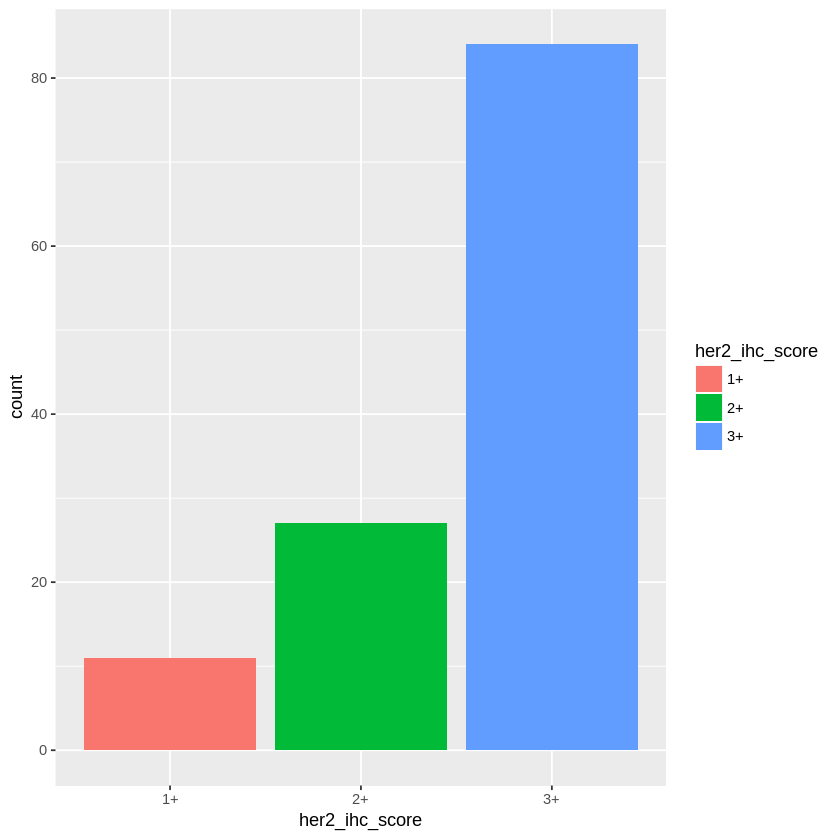

In [8]:
ghist <- ggplot(positive.scores, aes(x = her2_ihc_score, fill = her2_ihc_score))

gghist <- ghist + geom_bar()

gghist

As is expected, the majority of the samples are found in the 3+ group. 

# Run C5.0 algorithm

> I may delete this part since C5.0 seems unable to handle discrete variables (???) This doesn't really make sense to me because I once left sample ID in and it really jumped on that, but if I try to use percent positive or ihc score it ignores it completely. It's bizarre.

- Is there a patterned explanation for how SVM and RF misclassified these samples?

In [9]:
score.data <- merge(positive.scores[, c('Sample', 'her2_ihc_score')], misclassied, by = 'Sample')

perc.data <- merge(positive.percents, misclassied[, c('Sample', 'ERBB2', 'RF_classified', 'SVM_classified')], by = 'Sample')

kfold <- stratified(score.data, 'SVM_classified', .75)

results <- C5.0(subset(kfold, select = -c(SVM_classified, Sample, RF_classified, her2_status_by_ihc)), as.factor(kfold$SVM_classified), trials = 10, rules = T)

summary(results)


Call:
C5.0.default(x = subset(kfold, select = -c(SVM_classified,
 Sample, RF_classified, her2_status_by_ihc)), y
 = as.factor(kfold$SVM_classified), trials = 10, rules = T)


C5.0 [Release 2.07 GPL Edition]  	Mon Jul  9 22:43:22 2018
-------------------------------

Class specified by attribute `outcome'

Read 92 cases (23370 attributes) from undefined.data

-----  Trial 0:  -----

Rules:

Rule 0/1: (33/1, lift 2.7)
	C10orf68 <= 0.1248623
	GRB7 > 0.3803859
	TECR <= 0.2492222
	->  class Correct  [0.943]

Rule 0/2: (45, lift 1.5)
	GRB7 <= 0.3803859
	->  class Misclassified  [0.979]

Rule 0/3: (23, lift 1.5)
	C10orf68 > 0.1248623
	->  class Misclassified  [0.960]

Rule 0/4: (23, lift 1.5)
	TECR > 0.2492222
	->  class Misclassified  [0.960]

Default class: Misclassified

-----  Trial 1:  -----

Rules:

Rule 1/1: (20.3/3, lift 3.1)
	TMUB2 <= -1.056411
	->  class Correct  [0.820]

Rule 1/2: (4.5/0.8, lift 2.8)
	RALYL > -0.08045553
	->  class Correct  [0.731]

Rule 1/3: (6/1.5, lift 2.6)
	OR

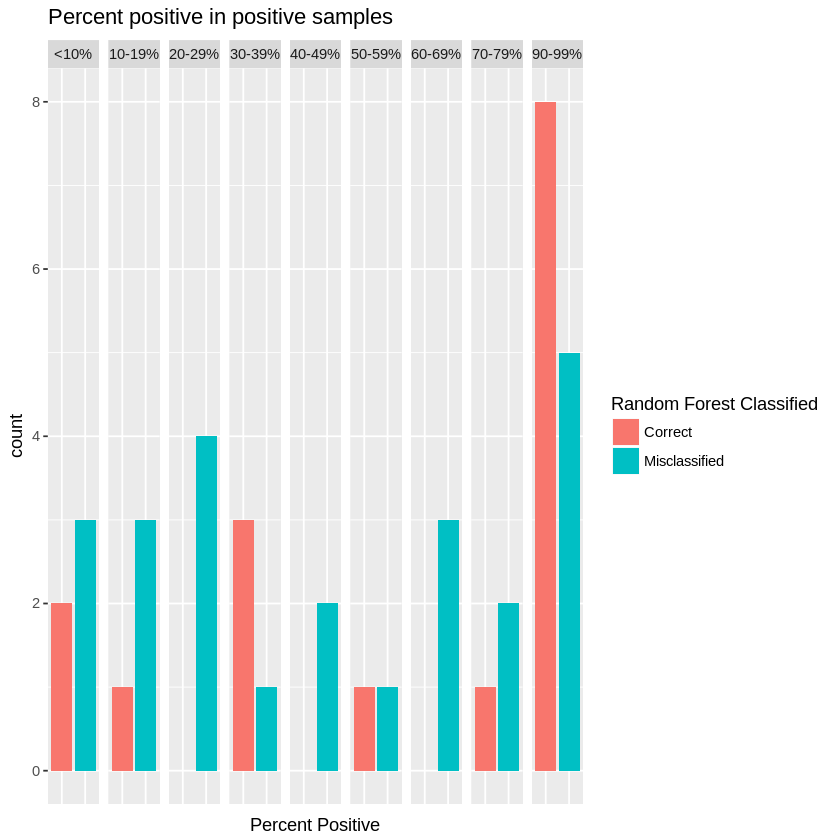

In [10]:
ghist <- ggplot(arrange(merge(positive.percents, misclassied[, c('ERBB2','Sample', 'RF_classified')], by = 'Sample'), her2_ihc_percent_positive, RF_classified),
               aes(x = RF_classified, fill = RF_classified))

gghist <- ghist + geom_bar(stat = "count") + facet_grid( ~ her2_ihc_percent_positive) + 
                labs(title = "Percent positive in positive samples", x = "Percent Positive", fill = "Random Forest Classified") + 
                theme(axis.ticks.x = element_blank(), axis.text.x = element_blank())

gghist

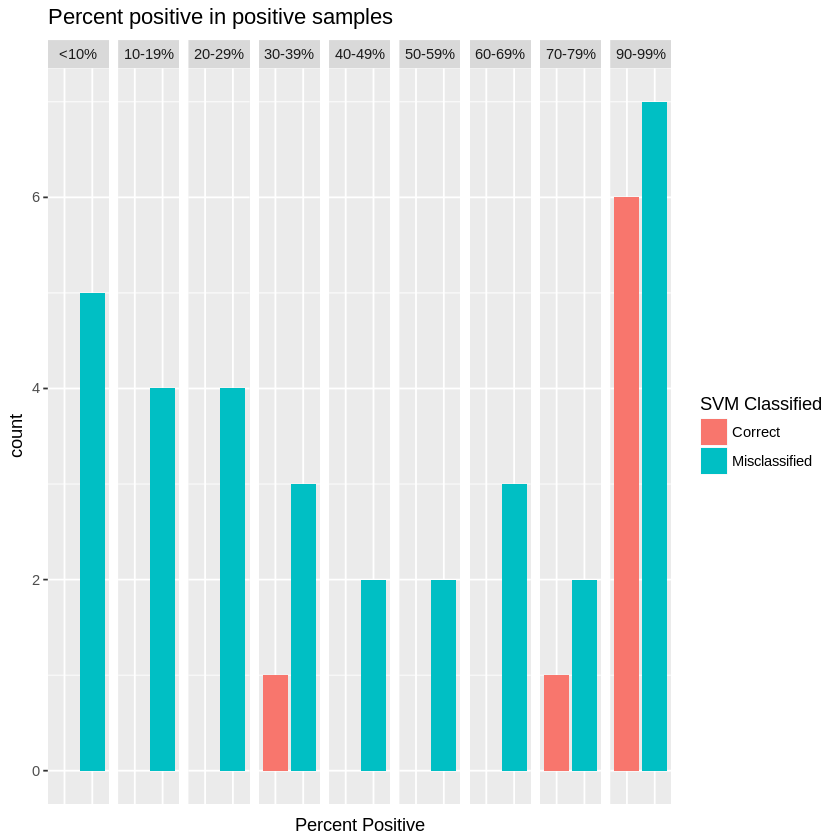

In [11]:
ghist <- ggplot(arrange(merge(positive.percents, misclassied[, c('ERBB2','Sample', 'SVM_classified')], by = 'Sample'), her2_ihc_percent_positive, SVM_classified),
               aes(x = SVM_classified, fill = SVM_classified))

gghist <- ghist + geom_bar(stat = "count") + facet_grid( ~ her2_ihc_percent_positive) + 
                labs(title = "Percent positive in positive samples", x = "Percent Positive", fill = "SVM Classified") + 
                theme(axis.ticks.x = element_blank(), axis.text.x = element_blank())

gghist

Each facet should be considered within itself. For example, we see that the 90-99% group has the most correctly classified samples in both SVM and RF out of all of the facets. However, we also see that a majority of the 90-99% samples were still misclassified by SVM. Thus, while percent positivity does seem to have a correlation with SVM's ability to correctly classifiy her2 positivity, we can also just assume that SVM with RBF kernel is really bad at her2 positivity classification.

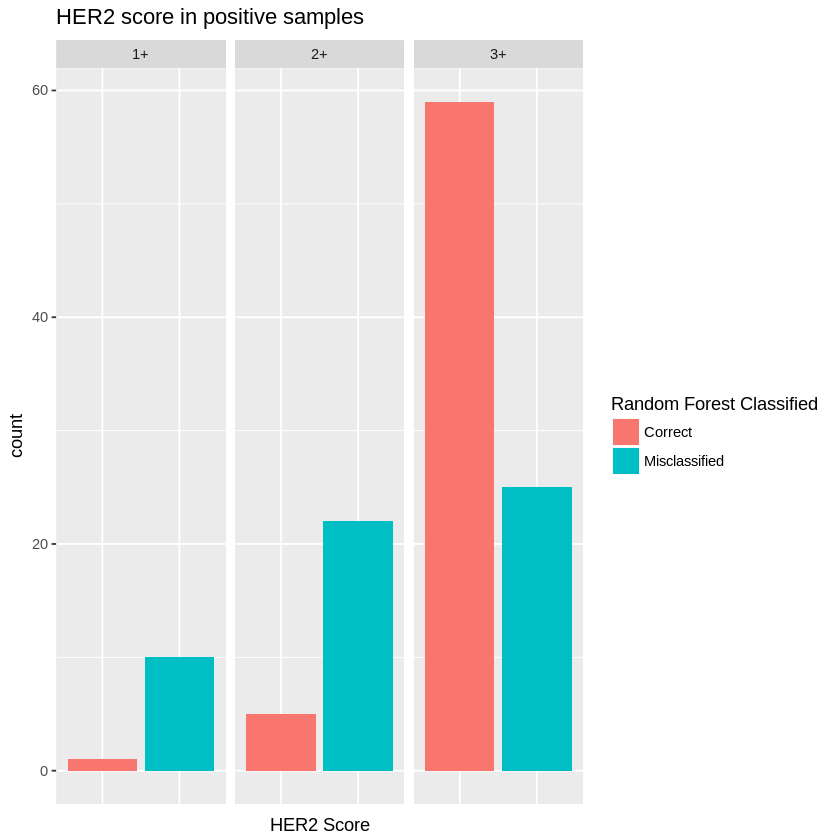

In [12]:
ghist <- ggplot(arrange(merge(positive.scores, misclassied[, c('ERBB2','Sample', 'RF_classified')], by = 'Sample'), her2_ihc_score, RF_classified),
               aes(x = RF_classified, fill = RF_classified))

gghist <- ghist + geom_bar(stat = "count") + facet_grid( ~ her2_ihc_score) + 
                labs(title = "HER2 score in positive samples", x = "HER2 Score", fill = "Random Forest Classified") + 
                theme(axis.ticks.x = element_blank(), axis.text.x = element_blank())

gghist

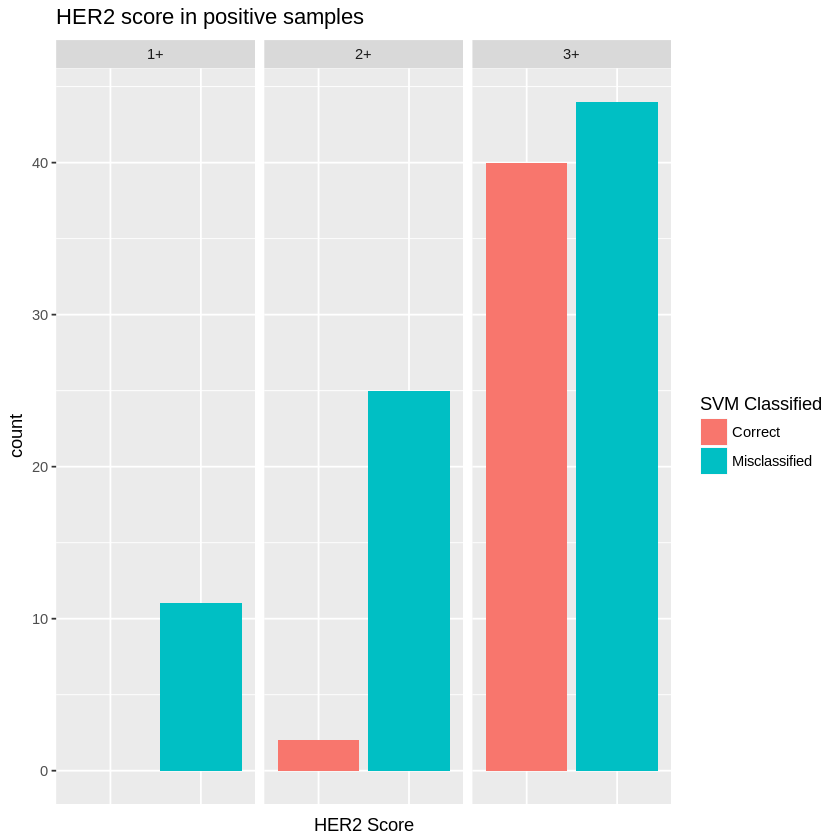

In [13]:
ghist <- ggplot(arrange(merge(positive.scores, misclassied[, c('ERBB2','Sample', 'SVM_classified')], by = 'Sample'), her2_ihc_score, SVM_classified),
               aes(x = SVM_classified, fill = SVM_classified))

gghist <- ghist + geom_bar(stat = "count") + facet_grid( ~ her2_ihc_score) + 
                labs(title = "HER2 score in positive samples", x = "HER2 Score", fill = "SVM Classified") + 
                theme(axis.ticks.x = element_blank(), axis.text.x = element_blank())

gghist

Again, we see some sort of correlation in that more samples are properly classified by both algorithms when her2 score is increased, however, SVM always misclassifies more samples than it does classify properly.